<a href="https://colab.research.google.com/github/Dimble777/Coco-annotation-for-object-detection/blob/main/Action_detection_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# ============================================================
# 📦 Setup (Colab environment)
# ============================================================
!pip install tensorflow opencv-python

#from google.colab import drive
#drive.mount('/content/drive')

from google.colab import files
import zipfile, os, numpy as np, cv2, tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2


# ============================================================
# ⚙️ Constants (update as needed)
# ============================================================
dataset_path = "/content/drive/MyDrive/data"  # path to extracted dataset
IMG_SIZE = (224, 224)
IMG_HEIGHT, IMG_WIDTH = IMG_SIZE
CHANNELS = 3
SEQ_LEN = 16
BATCH_SIZE = 4
EPOCHS = 10
NUM_ACTION_CLASSES = 5      # number of your real action classes
NUM_CLASSES_WITH_BG = NUM_ACTION_CLASSES + 1  # +1 for background

cls_loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
box_loss = tf.keras.losses.MeanSquaredError()


# ============================================================
# 🏷️ Action labels mapping
# ============================================================
ACTION_LABELS = {
    0: "using phone",
    1: "drinking water",
    2: "reading book",
    3: "writing notes",
    4: "eating food"
}




# ============================================================
# 🔍 Helper: Parse YOLO label file
# ============================================================
def parse_yolo_file(label_file):
    if not os.path.exists(label_file):
        return None
    with open(label_file, "r") as f:
        lines = [l.strip() for l in f.readlines() if l.strip()]
    if len(lines) == 0:
        return None
    parts = lines[0].split()
    if len(parts) < 5:
        return None
    cls = int(parts[0])
    cx, cy, w, h = map(float, parts[1:5])
    return (cls, cx, cy, w, h)

# ============================================================
# 🎞️ Dataset generator
# ============================================================
def video_clip_generator(split):
    split_dir = os.path.join(dataset_path, split)
    # Filter out non-directory entries like .DS_Store
    video_folders = sorted([f for f in os.listdir(split_dir) if os.path.isdir(os.path.join(split_dir, f))])

    for video_folder in video_folders:
        images_dir = os.path.join(split_dir, video_folder, "images")
        labels_dir = os.path.join(split_dir, video_folder, "labels")
        frames = sorted(os.listdir(images_dir))
        # Filter out non-image files (like .DS_Store)
        frames = [f for f in frames if f.lower().endswith(('.png', '.jpg', '.jpeg'))]


        # slide window for temporal clips
        for start in range(0, len(frames) - SEQ_LEN + 1, SEQ_LEN):
            clip_imgs = []
            bbox_targets = np.zeros((SEQ_LEN, 4), dtype=np.float32)
            class_targets = np.full((SEQ_LEN,), NUM_CLASSES_WITH_BG - 1, dtype=np.int32)
            mask = np.zeros((SEQ_LEN,), dtype=np.float32)

            for i, idx in enumerate(range(start, start + SEQ_LEN)):
                img_name = frames[idx]
                img_path = os.path.join(images_dir, img_name)
                lbl_path = os.path.join(labels_dir, img_name.replace(".jpg", ".txt").replace(".png", ".txt").replace(".jpeg", ".txt"))

                img = cv2.imread(img_path)

                # Check if image was loaded successfully
                if img is None:
                    print(f"Warning: Could not load image {img_path}. Skipping frame.")
                    continue  # Skip this frame and continue to the next

                img = cv2.resize(img, IMG_SIZE) / 255.0
                clip_imgs.append(img)

                if os.path.exists(lbl_path):
                    with open(lbl_path, "r") as f:
                        line = f.readline().strip().split()
                        # Check if line is not empty before accessing elements
                        if line and len(line) >= 5: # Check if line has at least 5 elements
                            try:
                                cls = int(line[0])
                                x, y, w, h = map(float, line[1:])
                                x_min = (x - w / 2) * IMG_SIZE[0]
                                y_min = (y - h / 2) * IMG_SIZE[1]
                                x_max = (x + w / 2) * IMG_SIZE[0]
                                y_max = (y + h / 2) * IMG_SIZE[1]
                                bbox_targets[i] = [x_min, y_min, x_max, y_max]
                                class_targets[i] = cls
                                mask[i] = 1.0
                            except ValueError:
                                print(f"Warning: Invalid data format in label file {lbl_path}. Skipping label.")
                        else:
                            print(f"Warning: Empty or invalid label file {lbl_path}. Skipping label.")


            # Only yield a clip if it has the required sequence length
            if len(clip_imgs) == SEQ_LEN:
                yield np.array(clip_imgs, dtype=np.float32), bbox_targets, class_targets, mask


# ============================================================
# 🔄 Create tf.data.Dataset
# ============================================================
def make_dataset(split, batch_size=BATCH_SIZE, shuffle=True):
    gen = lambda: video_clip_generator(split)
    output_signature = (
        tf.TensorSpec(shape=(SEQ_LEN, IMG_SIZE[0], IMG_SIZE[1], 3), dtype=tf.float32),
        tf.TensorSpec(shape=(SEQ_LEN, 4), dtype=tf.float32),
        tf.TensorSpec(shape=(SEQ_LEN,), dtype=tf.int32),
        tf.TensorSpec(shape=(SEQ_LEN,), dtype=tf.float32),
    )
    ds = tf.data.Dataset.from_generator(gen, output_signature=output_signature)
    if shuffle:
        ds = ds.shuffle(256)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    # Map dataset to (x, (bbox, class, mask))
    ds = ds.map(lambda imgs, bbox_targets, class_targets, mask: (imgs, (bbox_targets, class_targets, mask)))
    return ds


# ============================================================
# 🧠 Build model
# ============================================================
def build_model(seq_len=SEQ_LEN, img_size=IMG_SIZE, num_classes_with_bg=NUM_CLASSES_WITH_BG):
    inp = layers.Input(shape=(seq_len, img_size[0], img_size[1], 3))
    def frame_cnn():
        base = MobileNetV2(input_shape=(img_size[0], img_size[1], 3),
                           include_top=False, weights='imagenet', pooling='avg')
        base.trainable = False
        return base
    td = layers.TimeDistributed(frame_cnn())(inp)
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(td)
    per_frame = layers.TimeDistributed(layers.Dense(128, activation='relu'))(x)
    bbox_out = layers.TimeDistributed(layers.Dense(4, activation='sigmoid'), name="bbox")(per_frame)
    class_out = layers.TimeDistributed(layers.Dense(num_classes_with_bg), name="class_logits")(per_frame)
    model = models.Model(inputs=inp, outputs=[bbox_out, class_out])
    return model

# ============================================================
# ⚡ Custom training wrapper
# ============================================================
class DetModel(tf.keras.Model):
    def __init__(self, base_model, **kwargs):
        super().__init__(**kwargs)
        self.model = base_model
        self.cls_acc = tf.keras.metrics.SparseCategoricalAccuracy(name="frame_acc")
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")

    def call(self, inputs):
        return self.model(inputs)

    def compile(self, optimizer, cls_loss, box_loss):
        super().compile(optimizer=optimizer, loss={'bbox': box_loss, 'class_logits': cls_loss})
        self.cls_loss = cls_loss
        self.box_loss = box_loss


    @property
    def metrics(self):
        return [self.loss_tracker, self.cls_acc]

    def train_step(self, data):
        imgs, (bbox_true, class_true, mask) = data
        with tf.GradientTape() as tape:
            bbox_pred, class_logits = self.model(imgs, training=True)
            cls_l = self.cls_loss(class_true, class_logits)
            box_l = self.box_loss(bbox_true, bbox_pred)
            loss = cls_l + box_l

        grads = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
        self.loss_tracker.update_state(loss)
        self.cls_acc.update_state(class_true, class_logits)
        return {"loss": loss, "bbox": box_l, "class_logits": cls_l}

    def test_step(self, data):
        imgs, (bbox_true, class_true, mask) = data
        bbox_pred, class_logits = self.model(imgs, training=False)
        cls_l = self.cls_loss(class_true, class_logits)
        box_l = self.box_loss(bbox_true, bbox_pred)
        loss = cls_l + box_l
        self.loss_tracker.update_state(loss)
        self.cls_acc.update_state(class_true, class_logits)
        return {"loss": loss, "bbox": box_l, "class_logits": cls_l}


# ============================================================
# 🚀 Main (fixed)
# ============================================================
if __name__ == "__main__":
    train_ds = make_dataset("train").repeat()
    val_ds = make_dataset("val").repeat() # Added .repeat()

    base_model = build_model()
    det_model = DetModel(base_model)
    optimizer = tf.keras.optimizers.Adam(1e-4)

    det_model.compile(
        optimizer=optimizer,
        cls_loss=cls_loss,
        box_loss=box_loss
    )


# Estimate how many clips are in your dataset
num_train = sum(1 for _ in video_clip_generator("train"))
num_val = sum(1 for _ in video_clip_generator("val"))

# Calculate steps per epoch
steps_per_epoch = max(1, num_train // BATCH_SIZE)
validation_steps = max(1, num_val // BATCH_SIZE)

print(f"Steps per epoch: {steps_per_epoch}, Validation steps: {validation_steps}")

# Train with proper limits
history = det_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps
)


Steps per epoch: 240, Validation steps: 59
Epoch 1/10
  5/240 ━━━━━━━━━━━━━━━━━━━━ 15:01 4s/step - bbox: 15779.7676 - class_logits: 1.5326 - loss: 15781.2998Warning: Empty or invalid label file /content/drive/MyDrive/data/train/OutPut0.5.mp4/labels/000032.txt. Skipping label.
 25/240 ━━━━━━━━━━━━━━━━━━━━ 13:53 4s/step - bbox: 16314.8994 - class_logits: 1.4227 - loss: 16316.3232Warning: Invalid data format in label file /content/drive/MyDrive/data/train/OutPut1/labels/000014.txt. Skipping label.
172/240 ━━━━━━━━━━━━━━━━━━━━ 4:16 4s/step - bbox: 13791.9990 - class_logits: 0.4665 - loss: 13792.4658Warning: Empty or invalid label file /content/drive/MyDrive/data/train/OutPut99.2/labels/000224.txt. Skipping label.
173/240 ━━━━━━━━━━━━━━━━━━━━ 4:12 4s/step - bbox: 13786.6738 - class_logits: 0.4654 - loss: 13787.1396Warning: Empty or invalid label file /content/drive/MyDrive/data/train/OutPut99.2/labels/000312.txt. Skipping label.
174/240 ━━━━━━━━━━━━━━━━━━━━ 4:08 4s/step - bbox: 13774.6348 -

In [2]:
import glob

invalid = []
for file in glob.glob("/content/drive/MyDrive/data/train/**/labels/*.txt", recursive=True):
    with open(file) as f:
        lines = f.read().strip().splitlines()
        for line in lines:
            parts = line.strip().split()
            if len(parts) < 5:
                invalid.append((file, line))

print(f"Total invalid label lines: {len(invalid)}")
for f, l in invalid[:10]:
    print(f"{f} -> {l}")


Total invalid label lines: 1
/content/drive/MyDrive/data/train/OutPut99.2/labels/000224.txt -> 0.336198 0.728704 0.096354 0.179630


In [5]:
# Define constants
SEQ_LEN = 16       # number of frames per clip
IMG_SIZE = 224     # image size used in training
BATCH_SIZE = 4     # batch size you used earlier


In [6]:
def load_dataset(image_dir, label_dir):
    import tensorflow as tf, os

    image_paths = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith(".jpg")])
    label_paths = sorted([os.path.join(label_dir, f) for f in os.listdir(label_dir) if f.endswith(".txt")])

    def parse_sample(img_path, label_path):
        img = tf.io.read_file(img_path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
        img = img / 255.0

        # parse label file (YOLO format)
        label_text = tf.io.read_file(label_path)
        label_lines = tf.strings.strip(tf.strings.split(label_text, "\n"))
        label_splits = tf.strings.split(label_lines, " ")

        # fallback for empty labels
        bbox = tf.zeros((SEQ_LEN, 4))
        cls = tf.zeros((SEQ_LEN,), dtype=tf.int32)

        return img, (bbox, cls)

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_paths))
    dataset = dataset.map(parse_sample, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return dataset


In [7]:
val_image_dir = "/content/drive/MyDrive/data/val/OutPut126.1/images"
val_label_dir = "/content/drive/MyDrive/data/val/OutPut126.1/labels"

val_ds = load_dataset(val_image_dir, val_label_dir)


In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# --- simple example backbone ---
def build_detector_model(seq_len=16, img_size=224):
    inputs = keras.Input((img_size, img_size, 3))
    x = keras.applications.MobileNetV2(input_shape=(img_size,img_size,3),
                                       include_top=False,
                                       weights="imagenet")(inputs)
    x = layers.GlobalAveragePooling2D()(x)

    bbox_out = layers.Dense(4, name="bbox")(x)
    class_out = layers.Dense(3, activation="softmax", name="class_logits")(x)
    return keras.Model(inputs, [bbox_out, class_out], name="DetModel")

det_model = build_detector_model()


In [12]:
det_model.save_weights("/content/drive/MyDrive/det_model.weights.h5")


In [13]:
det_model.load_weights("/content/drive/MyDrive/det_model.weights.h5")


In [16]:

print("bbox_pred shape:", bbox_pred.shape)
print("class_pred shape:", class_pred.shape)
print("sample_clip shape:", sample_clip.shape)



bbox_pred shape: (4, 4)
class_pred shape: (4, 3)
sample_clip shape: (4, 224, 224, 3)


In [22]:
SEQ_LEN = 16  # or whatever number of frames per clip you use
NUM_CLASSES = 5  # example — change to match your dataset


In [23]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_model(seq_len=SEQ_LEN, num_classes=NUM_CLASSES):
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=(224, 224, 3),
        include_top=False,
        weights="imagenet",
        pooling="avg"
    )

    inputs = layers.Input(shape=(seq_len, 224, 224, 3))
    x = layers.TimeDistributed(base_model)(inputs)
    x = layers.LSTM(128, return_sequences=True)(x)

    # Bounding box output (x, y, w, h) per frame
    bbox_output = layers.TimeDistributed(layers.Dense(4, activation="sigmoid"), name="bbox")(x)

    # Class output per frame
    class_output = layers.TimeDistributed(layers.Dense(num_classes, activation="softmax"), name="class")(x)

    model = models.Model(inputs=inputs, outputs=[bbox_output, class_output])
    return model

det_model = build_model()
det_model.compile(
    optimizer='adam',
    loss={'bbox': 'mse', 'class': 'sparse_categorical_crossentropy'},
    metrics={'class': 'accuracy'}
)


In [26]:
import tensorflow as tf
import numpy as np, os, cv2
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2

# --- Constants (must match your training setup)
dataset_path = "/content/drive/MyDrive/data"
IMG_SIZE = (224, 224)
SEQ_LEN = 16
BATCH_SIZE = 4
NUM_ACTION_CLASSES = 5
NUM_CLASSES_WITH_BG = NUM_ACTION_CLASSES + 1

# --- Helper: parse YOLO txt
def parse_yolo_file(label_file):
    if not os.path.exists(label_file):
        return None
    with open(label_file) as f:
        lines = [l.strip() for l in f.readlines() if l.strip()]
    if not lines: return None
    parts = lines[0].split()
    if len(parts) < 5: return None
    cls = int(parts[0])
    cx, cy, w, h = map(float, parts[1:5])
    return (cls, cx, cy, w, h)

# --- Generator that yields (clip, bbox, class, mask)
def video_clip_generator(split):
    split_dir = os.path.join(dataset_path, split)
    for vid in os.listdir(split_dir):
        vpath = os.path.join(split_dir, vid)
        if not os.path.isdir(vpath): continue
        imgs_dir = os.path.join(vpath, "images")
        lbls_dir = os.path.join(vpath, "labels")
        frames = sorted([f for f in os.listdir(imgs_dir) if f.lower().endswith((".jpg",".png",".jpeg"))])

        for start in range(0, len(frames) - SEQ_LEN + 1, SEQ_LEN):
            clip, bbox_t, class_t, mask = [], np.zeros((SEQ_LEN,4)), np.zeros((SEQ_LEN,),int), np.zeros((SEQ_LEN,))
            for i, idx in enumerate(range(start, start + SEQ_LEN)):
                img_path = os.path.join(imgs_dir, frames[idx])
                lbl_path = os.path.join(lbls_dir, frames[idx].rsplit(".",1)[0]+".txt")
                img = cv2.imread(img_path)
                if img is None: continue
                img = cv2.resize(img, IMG_SIZE)/255.0
                clip.append(img)
                if os.path.exists(lbl_path):
                    data = parse_yolo_file(lbl_path)
                    if data:
                        cls, cx, cy, w, h = data
                        x1=(cx-w/2)*IMG_SIZE[0]; y1=(cy-h/2)*IMG_SIZE[1]
                        x2=(cx+w/2)*IMG_SIZE[0]; y2=(cy+h/2)*IMG_SIZE[1]
                        bbox_t[i]=[x1,y1,x2,y2]; class_t[i]=cls; mask[i]=1
            if len(clip)==SEQ_LEN:
                yield np.array(clip,np.float32),bbox_t,class_t,mask

# --- Convert generator to tf.data
def make_dataset(split, batch_size=BATCH_SIZE, shuffle=True):
    gen=lambda: video_clip_generator(split)
    output_signature=(
        tf.TensorSpec((SEQ_LEN, IMG_SIZE[0], IMG_SIZE[1],3), tf.float32),
        tf.TensorSpec((SEQ_LEN,4), tf.float32),
        tf.TensorSpec((SEQ_LEN,), tf.int32),
        tf.TensorSpec((SEQ_LEN,), tf.float32)
    )
    ds=tf.data.Dataset.from_generator(gen,output_signature=output_signature)
    if shuffle: ds=ds.shuffle(64)
    ds=ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    ds=ds.map(lambda imgs,b,c,m:(imgs,(b,c,m)))
    return ds

# --- Simple model (same as before)
def build_model(seq_len=SEQ_LEN, img_size=IMG_SIZE, num_classes_with_bg=NUM_CLASSES_WITH_BG):
    inp=layers.Input((seq_len,img_size[0],img_size[1],3))
    base=MobileNetV2(input_shape=(img_size[0],img_size[1],3),include_top=False,weights="imagenet",pooling="avg")
    base.trainable=False
    td=layers.TimeDistributed(base)(inp)
    x=layers.Bidirectional(layers.LSTM(128,return_sequences=True))(td)
    x=layers.TimeDistributed(layers.Dense(128,activation="relu"))(x)
    bbox_out=layers.TimeDistributed(layers.Dense(4,activation="sigmoid"),name="bbox")(x)
    class_out=layers.TimeDistributed(layers.Dense(num_classes_with_bg),name="class_logits")(x)
    return models.Model(inp,[bbox_out,class_out])

# --- Instantiate and load weights (optional)
det_model = build_model()


In [28]:
import os

def check_labels(base_dir):
    bad_files = []
    for root, _, files in os.walk(base_dir):
        for f in files:
            if f.endswith(".txt"):
                path = os.path.join(root, f)
                with open(path) as fh:
                    for line in fh:
                        parts = line.strip().split()
                        if not parts: continue
                        try:
                            int(parts[0])
                            [float(x) for x in parts[1:5]]
                        except:
                            bad_files.append(path)
                            break
    return bad_files

bad = check_labels("/content/drive/MyDrive/data/val")
print("Bad label files:", bad)


Bad label files: ['/content/drive/MyDrive/data/val/OutPut126.1/labels/000038.txt', '/content/drive/MyDrive/data/val/OutPut126.1/labels/000029.txt', '/content/drive/MyDrive/data/val/OutPut126.1/labels/000037.txt', '/content/drive/MyDrive/data/val/OutPut126.1/labels/000031.txt', '/content/drive/MyDrive/data/val/OutPut126.1/labels/000032.txt', '/content/drive/MyDrive/data/val/OutPut126.1/labels/000033.txt', '/content/drive/MyDrive/data/val/OutPut126.1/labels/000035.txt', '/content/drive/MyDrive/data/val/OutPut126.1/labels/000036.txt', '/content/drive/MyDrive/data/val/OutPut126.1/labels/000034.txt', '/content/drive/MyDrive/data/val/OutPut126.1/labels/000030.txt']


In [29]:
import os

bad_files = [
    '/content/drive/MyDrive/data/val/OutPut126.1/labels/000038.txt',
    '/content/drive/MyDrive/data/val/OutPut126.1/labels/000029.txt',
    '/content/drive/MyDrive/data/val/OutPut126.1/labels/000037.txt',
    '/content/drive/MyDrive/data/val/OutPut126.1/labels/000031.txt',
    '/content/drive/MyDrive/data/val/OutPut126.1/labels/000032.txt',
    '/content/drive/MyDrive/data/val/OutPut126.1/labels/000033.txt',
    '/content/drive/MyDrive/data/val/OutPut126.1/labels/000035.txt',
    '/content/drive/MyDrive/data/val/OutPut126.1/labels/000036.txt',
    '/content/drive/MyDrive/data/val/OutPut126.1/labels/000034.txt',
    '/content/drive/MyDrive/data/val/OutPut126.1/labels/000030.txt'
]

def clean_yolo_labels(file_path):
    valid_lines = []
    with open(file_path, "r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) == 5:
                try:
                    int(parts[0])
                    [float(x) for x in parts[1:5]]
                    valid_lines.append(line.strip())
                except:
                    continue
    with open(file_path, "w") as f:
        f.write("\n".join(valid_lines))
    print(f"✅ Cleaned: {file_path} ({len(valid_lines)} valid lines kept)")

for f in bad_files:
    clean_yolo_labels(f)


✅ Cleaned: /content/drive/MyDrive/data/val/OutPut126.1/labels/000038.txt (0 valid lines kept)
✅ Cleaned: /content/drive/MyDrive/data/val/OutPut126.1/labels/000029.txt (0 valid lines kept)
✅ Cleaned: /content/drive/MyDrive/data/val/OutPut126.1/labels/000037.txt (0 valid lines kept)
✅ Cleaned: /content/drive/MyDrive/data/val/OutPut126.1/labels/000031.txt (0 valid lines kept)
✅ Cleaned: /content/drive/MyDrive/data/val/OutPut126.1/labels/000032.txt (0 valid lines kept)
✅ Cleaned: /content/drive/MyDrive/data/val/OutPut126.1/labels/000033.txt (0 valid lines kept)
✅ Cleaned: /content/drive/MyDrive/data/val/OutPut126.1/labels/000035.txt (0 valid lines kept)
✅ Cleaned: /content/drive/MyDrive/data/val/OutPut126.1/labels/000036.txt (0 valid lines kept)
✅ Cleaned: /content/drive/MyDrive/data/val/OutPut126.1/labels/000034.txt (0 valid lines kept)
✅ Cleaned: /content/drive/MyDrive/data/val/OutPut126.1/labels/000030.txt (0 valid lines kept)


In [30]:
val_ds = make_dataset("val")
sample_clip_batch = next(iter(val_ds.take(1)))


1/1 ━━━━━━━━━━━━━━━━━━━━ 24s 24s/step


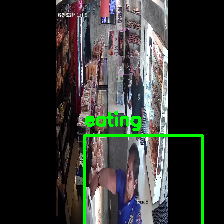

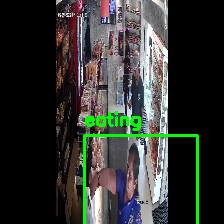

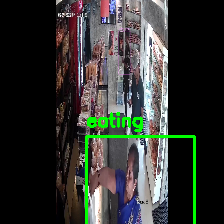

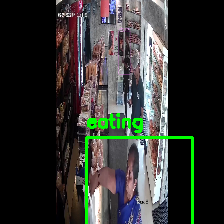

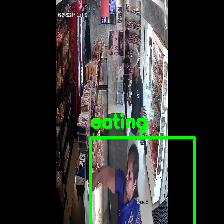

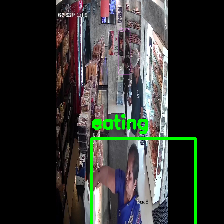

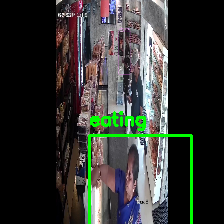

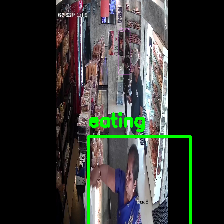

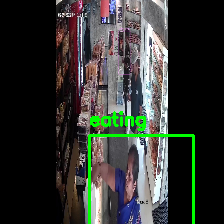

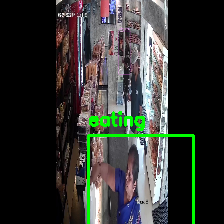

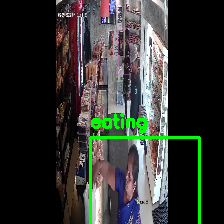

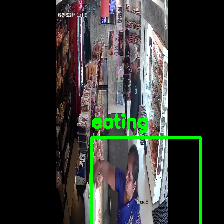

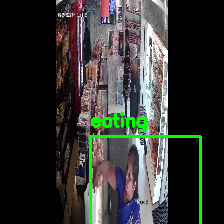

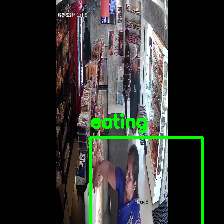

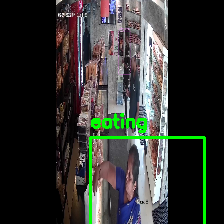

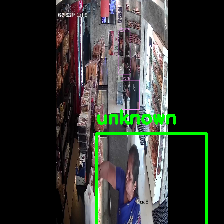

In [31]:
from google.colab.patches import cv2_imshow
import numpy as np, cv2

val_ds = make_dataset("val")

sample_clip_batch = next(iter(val_ds.take(1)))
sample_clip = sample_clip_batch[0]
bbox_pred, class_pred = det_model.predict(sample_clip)

ACTION_LABELS = {0:"using phone",1:"drinking",2:"writing",3:"eating",4:"talking"}

SEQ_LEN = sample_clip.shape[1]

for frame_idx in range(SEQ_LEN):
    frame = (sample_clip[0][frame_idx].numpy()*255).astype("uint8")
    bbox = bbox_pred[0][frame_idx]
    cls_id = np.argmax(class_pred[0][frame_idx])
    action_name = ACTION_LABELS.get(int(cls_id),"unknown")

    h,w,_ = frame.shape
    x,y,bw,bh = bbox
    x1,y1 = int(x*w), int(y*h)
    x2,y2 = int((x+bw)*w), int((y+bh)*h)

    cv2.rectangle(frame,(x1,y1),(x2,y2),(0,255,0),2)
    cv2.putText(frame,action_name,(x1,y1-10),cv2.FONT_HERSHEY_SIMPLEX,0.6,(0,255,0),2)
    cv2_imshow(frame)
